# Classification - Determine International Rating 

In [240]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import math
import re
warnings.filterwarnings('ignore')
%matplotlib inline

In [241]:
# Step 1. Prepare data

X:  (3563, 32)
1.0    3236
2.0     262
3.0      65
Name: International Reputation, dtype: int64
n_classes:  3


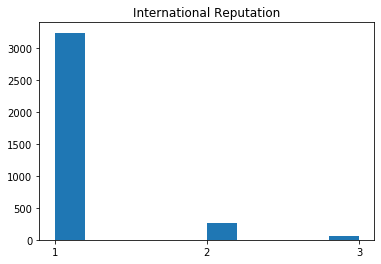

In [242]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report

# Read original data
sample_data = pd.read_csv('fifa19_features_reduced_data.csv', encoding='utf-8')

# Separate internation rating result with rest
y = sample_data['International Reputation']
X = sample_data.drop('International Reputation', axis=1)
print('X: ', X.shape)

# Binarize the rating result
# Rating score 5 records is only 6 / 18159, score 4 is 51 / 18159, 
# so it cannot be predicated with too little data,
# we convert the score 5 and 4 to 3 so only choose rating scores 1, 2, 3, 4 to classify.
sample_data['International Reputation'].loc[sample_data['International Reputation'] == 5] = 3
sample_data['International Reputation'].loc[sample_data['International Reputation'] == 4] = 3
print(sample_data['International Reputation'].value_counts())

y_n = sample_data['International Reputation']

y = label_binarize(y, classes=[1, 2, 3])
n_classes = y.shape[1]
print('n_classes: ', n_classes)

fig, ax = plt.subplots()
ax.hist(sample_data['International Reputation'])
ax.locator_params(integer=True)
plt.title('International Reputation')
plt.show()

X_train:  (2375, 32) X_test:  (1188, 32)
Rating Score value counts:  1
1    2162
0     213
dtype: int64


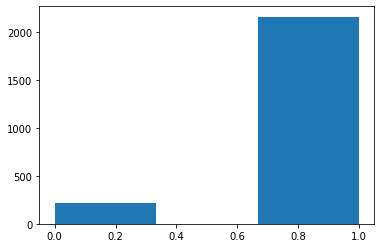

 
Rating Score value counts:  2
0    2203
1     172
dtype: int64


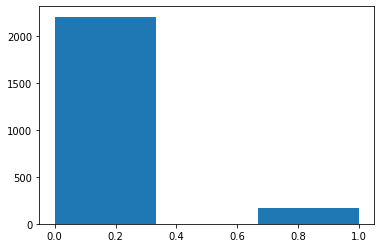

 
Rating Score value counts:  3
0    2334
1      41
dtype: int64


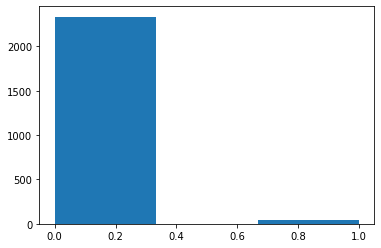

 
X_n_train:  (2375, 32) y_n_ftest:  (1188, 32)


In [243]:
# Divide data into training set and testing set
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=1/3,random_state=1)
print('X_train: ', X_train.shape, 'X_test: ', X_test.shape)

#print(y_train)
for i in range(n_classes):
    print("Rating Score value counts: ", i + 1)
    print(pd.value_counts(y_train[:, i]))
    plt.hist(y_train[:, i], bins=3)
    plt.show()
    print(" ")

X_n_train,X_n_test,y_n_train,y_n_test = train_test_split(X,y_n,test_size=1/3,random_state=1)
print('X_n_train: ', X_n_train.shape, 'y_n_ftest: ', X_test.shape)

In [244]:
from imblearn.over_sampling import SMOTE

# Use over-sampling to increate rating 2, 3 records
#smote = SMOTE(ratio='minority', random_state=1, k_neighbors=3)
#X_train, y_train = smote.fit_sample(X_train, y_train)
#print('X_train: ', X_train.shape, 'y_train: ', y_train.shape)

#print(y_train)
# for i in range(n_classes):
#     print("Rating Score value counts: ", i + 1)
#     print(pd.value_counts(y_train[:, i]))
#     plt.hist(y_train[:, i], bins=3)
#     plt.show()
#     print(" ")

In [245]:
# Standardize records
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 
print('X_train: ', X_train.shape, 'X_test: ', X_test.shape)

X_train:  (2375, 32) X_test:  (1188, 32)


In [246]:
# Step 2. Solve with Logistic Regression

In [362]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, make_scorer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics

from scipy import interp
from itertools import cycle
import time

def show_time_spent(start_time):
    time_used = time.time() - start_time
    return "{}:{}:{}".format(int(time_used / 3600), int(time_used % 3600 / 60), int(time_used % 60))

# Draw feature importance
def show_feature_importance(one_vs_rest_clf, feature_importance_func=None, columns_names=X.columns, index=-1, max_cols=-1):
    clfs = one_vs_rest_clf.estimators_
    
    if index >= 0:
        if feature_importance_func is None:
            feature_importance = clfs[index].feature_importances_
        else:
            feature_importance = feature_importance_func(clfs[index])
        
        last_col = max_cols if max_cols > 0 else len(feature_importance)
        
        feat_imp = pd.Series(feature_importance[0:last_col], index=columns_names[0:last_col]).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances for Rating {}'.format(index + 1))
        plt.show()
        return
    
    for i in range(len(clfs)):
        if feature_importance_func is None:
            feature_importance = clfs[i].feature_importances_
        else:
            feature_importance = feature_importance_func(clfs[i])
        
        last_col = max_cols if max_cols > 0 else len(feature_importance)
        feat_imp = pd.Series(feature_importance[0:last_col], index=columns_names[0:last_col]).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances for Rating {}'.format(i + 1))
        plt.show()
        
# Create function to store ROC computation results for all classification classes
def compute_roc_auc_in_classes(test_data, test_result, num_classes=n_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    roc_result = {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc }
    
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(test_data[:, i], test_result[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(test_data.ravel(), test_result.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    # Compute macro-average ROC curve and ROC area
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    return roc_result

# Draw ROC plot based on ROC computation result
def draw_roc_auc_in_classes(roc_auc_result, learn_method, num_classes=n_classes):
    fpr = roc_auc_result['fpr']
    tpr = roc_auc_result['tpr']
    roc_auc = roc_auc_result['roc_auc']
    
    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["macro"], tpr["macro"],
             label='Average ROC (area = {0:0.4f})'.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=1,
                 label='ROC of rating {0} (area = {1:0.4f})'.format((i + 1), roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for {}'.format(learn_method))
    plt.legend(loc="lower right")
    plt.show()

def print_confusion_matix(y_test_data, y_pred_data):
    # Print accuracy and confusion matrix
    print()
    print(multilabel_confusion_matrix(y_true=y_test_data, y_pred=y_pred_data))
    print(classification_report(y_true=y_test_data, y_pred=y_pred_data, digits=4))
    print()

In [248]:
from sklearn.linear_model import LogisticRegression

# create logistic regression model for multi-class and one vs rest mode
logreg = OneVsRestClassifier(LogisticRegression(multi_class='ovr', random_state=1))
#print("parameters: ", logreg.get_params().keys())

# Create GridSearch to find best model
penalty_param = ['l1', 'l2']
class_weight_param = ['balanced']
solver_param = ['liblinear']
C_param = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 2000, 3000]
max_iter_param = [1000]
hyperparameters = dict(estimator__C=C_param, estimator__penalty=penalty_param,
                       estimator__class_weight=class_weight_param,
                       estimator__solver=solver_param, estimator__max_iter=max_iter_param)

# Fit model using gridsearch
grid_logreg = GridSearchCV(logreg, hyperparameters, scoring = 'accuracy', cv=5, verbose=True, n_jobs=-1)
#print(metrics.SCORERS.keys())

timer_check = time.time()
print('start training')

# Best model
best_logreg = grid_logreg.fit(X_train, y_train)

#Print all the Parameters that gave the best results:
print('Best Parameters', grid_logreg.best_estimator_)

print('training spent: ', show_time_spent(timer_check))

start training
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.3s


Best Parameters OneVsRestClassifier(estimator=LogisticRegression(C=2000,
                                                 class_weight='balanced',
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='ovr', n_jobs=None,
                                                 penalty='l2', random_state=1,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)
training spent:  0:0:24


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   24.0s finished


In [249]:
timer_check = time.time()
print('start training')

# Compute test scores
y_score = best_logreg.predict(X_test)

print('Validation spent: ', show_time_spent(timer_check))

# Print confusion scores
print_confusion_matix(y_test, y_score)

start training
Validation spent:  0:0:0

[[[ 109    5]
  [ 139  935]]

 [[ 918  180]
  [   4   86]]

 [[1126   38]
  [  11   13]]]
              precision    recall  f1-score   support

           0     0.9947    0.8706    0.9285      1074
           1     0.3233    0.9556    0.4831        90
           2     0.2549    0.5417    0.3467        24

   micro avg     0.8226    0.8704    0.8458      1188
   macro avg     0.5243    0.7893    0.5861      1188
weighted avg     0.9289    0.8704    0.8830      1188
 samples avg     0.8464    0.8704    0.8544      1188




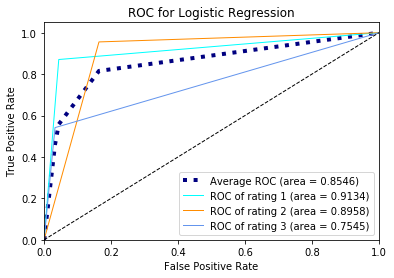

Best ROC score for logistic regression: 0.8546
Model accuracy is 0.8223905723905723


In [251]:
# Compute ROC AUC score
logreg_result = compute_roc_auc_in_classes(y_test, y_score, num_classes=n_classes)

# Draw ROC plot
draw_roc_auc_in_classes(logreg_result, 'Logistic Regression', num_classes=n_classes)

# Assign Best score
roc_logreg = logreg_result['roc_auc']['macro']
print("Best ROC score for logistic regression: {0:0.4f}".format(roc_logreg))

score_logreg = best_logreg.score(X_test, y_test)
print('Model accuracy is', score_logreg)

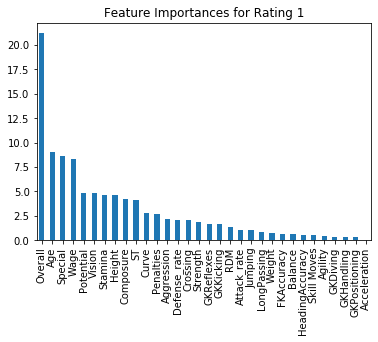

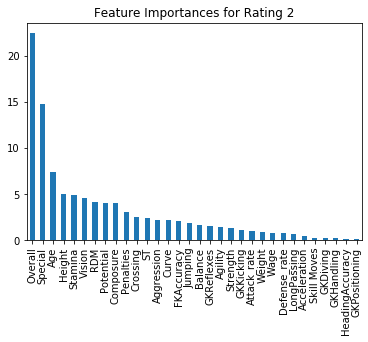

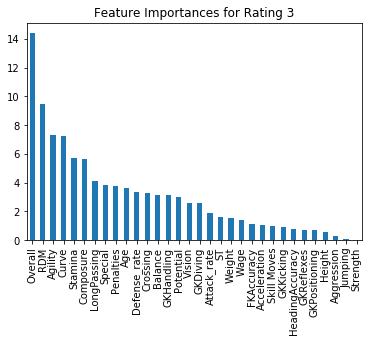

In [252]:
def get_log_reg_feature_importance(log_reg_clf):
    feature_importance = abs(log_reg_clf.coef_[0])
    feature_importance = 100.0 * (feature_importance / feature_importance.sum())
    return feature_importance

show_feature_importance(grid_logreg.best_estimator_, feature_importance_func=get_log_reg_feature_importance)

In [253]:
# Step 3. Solve with Decision Tree

In [255]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

# create Decision Tree model for multi-class and one vs rest mode
decision_tree = OneVsRestClassifier(DecisionTreeClassifier(random_state=1))
print('Created decision_tree')
#print("parameters: ", decision_tree.get_params().keys())

# Create GridSearch to find best model
# Tested: 
#    criterion_param = ['entropy', 'gini']
#    max_depth_param = [ 10, 20, 40]
#    max_leaf_nodes_param = [ 20, 50, 100 ]
#    max_features_param = [ 20, 40, X_train.shape[1]]
#    n_estimators_param = [ 100, 500, 1000 ]
#    max_samples_param = [ 100, 500, 1000 ]
#    Best Parameters {'estimator__base_estimator__criterion': 'gini', 
#                     'estimator__base_estimator__max_depth': 20, 
#                     'estimator__base_estimator__max_features': 56, 
#                     'estimator__base_estimator__max_leaf_nodes': 50, 
#                     'estimator__max_samples': 1000, 
#                     'estimator__n_estimators': 500}
# So to save time, only run with best parameters
criterion_param = [ 'gini']
max_depth_param = [ 10, 20, 40 ]
max_leaf_nodes_param = [ 50 ]
max_features_param = [ 10, 20, X_train.shape[1] ]

hyperparameters = dict(estimator__criterion=criterion_param, 
                       estimator__max_depth=max_depth_param,
                       estimator__max_leaf_nodes=max_leaf_nodes_param, 
                       estimator__max_features=max_features_param)

# Fit model using gridsearch
score_making_func = make_scorer(roc_auc_score, average='macro') 
grid_decision_tree = GridSearchCV(decision_tree, hyperparameters, scoring = score_making_func, cv=5, verbose=False, n_jobs=-1)
#print(grid_decision_tree.get_params().keys())
#print(sorted(metrics.SCORERS.keys()))

Created decision_tree


In [257]:
# Compute test scores
timer_check = time.time()
print('start training')

# Best model
best_decision_tree = grid_decision_tree.fit(X_train, y_train)

print('training spent: ', show_time_spent(timer_check))

#Print all the Parameters that gave the best results:
print('Best Parameters', grid_decision_tree.best_estimator_)

start training
training spent:  0:0:0
Best Parameters OneVsRestClassifier(estimator=DecisionTreeClassifier(class_weight=None,
                                                     criterion='gini',
                                                     max_depth=10,
                                                     max_features=20,
                                                     max_leaf_nodes=50,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     presort=False,
                                                     random_state=1,
                                                     splitter='best')

In [258]:
# Compute test scores
y_score = best_decision_tree.predict(X_test)
print('y_score: ', y_score.shape)

# Print confusion scores
print_confusion_matix(y_test, y_score)

y_score:  (1188, 3)

[[[  56   58]
  [  36 1038]]

 [[1049   49]
  [  58   32]]

 [[1151   13]
  [  15    9]]]
              precision    recall  f1-score   support

           0     0.9471    0.9665    0.9567      1074
           1     0.3951    0.3556    0.3743        90
           2     0.4091    0.3750    0.3913        24

   micro avg     0.8999    0.9082    0.9041      1188
   macro avg     0.5837    0.5657    0.5741      1188
weighted avg     0.8944    0.9082    0.9011      1188
 samples avg     0.8900    0.9082    0.8959      1188




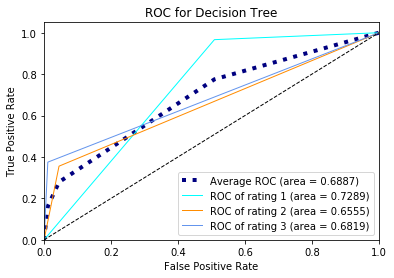

Best ROC score for Decision Tree: 0.6887
Model accuracy is 0.6887448489952869


In [260]:
# Compute ROC AUC score
decision_tree_result = compute_roc_auc_in_classes(y_test, y_score, num_classes=n_classes)

# Draw ROC plot
draw_roc_auc_in_classes(decision_tree_result, 'Decision Tree', num_classes=n_classes)

# Assign Best ROC value
roc_decision_tree = decision_tree_result['roc_auc']["macro"]
print('Best ROC score for Decision Tree: {0:0.4f}'.format(roc_decision_tree))

score_decision_tree = best_decision_tree.score(X_test, y_test)
print('Model accuracy is', score_decision_tree)

In [261]:
# Step 4. Solve with SVM

In [262]:
from sklearn.svm import LinearSVC

# create model for multi-class and one vs rest mode
linear_svc = OneVsRestClassifier(LinearSVC(multi_class='ovr', random_state=1))
print('Created SVM')
#print("parameters: ", linear_svc.get_params().keys())

# Create GridSearch to find best model
# Tested:
#    max_iter_param = [50, 100, 200, 500, 1000]
#    dul_param = [True, False]
#    C_param = [ 1, 4, 6, 10, 20 ]
#    fit_intercept_param  = [True, False]
#    n_estimators_param = [ 100, 500, 1000 ]
#    max_samples_param = [ 100, 500, 1000 ]
# Best Parameters {'estimator__base_estimator__C': 6, 
#                  'estimator__base_estimator__dual': True, 
#                  'estimator__base_estimator__fit_intercept': False, 
#                  'estimator__base_estimator__max_iter': 100, 
#                  'estimator__max_samples': 1000, 
#                  'estimator__n_estimators': 100}
# To save time, only run with best parameters
max_iter_param = [10000]
dul_param = [True]
C_param = [ 0.01, 0.1, 1 ]
fit_intercept_param  = [False]
loss_param = ['squared_hinge', 'hinge']
class_weight_param = ['balanced']
#n_estimators_param = [ 100 ]
#max_samples_param = [ X_train.shape[0] - 1 ]

hyperparameters = dict(estimator__C=C_param, 
                       estimator__max_iter=max_iter_param,
                       estimator__fit_intercept=fit_intercept_param,
                       estimator__dual=dul_param,
                       estimator__loss=loss_param,
                       estimator__class_weight=class_weight_param
                       )

# Fit model using gridsearch
grid_linear_svc = GridSearchCV(linear_svc, hyperparameters, scoring='accuracy', cv=5, verbose=True, n_jobs=-1)
#print(grid_linear_svc.get_params().keys())

Created SVM


In [263]:
timer_check = time.time()
print('start training')

# Best model
best_linear_svc = grid_linear_svc.fit(X_train, y_train)

print('training spent: ', show_time_spent(timer_check))

#Print all the Parameters that gave the best results:
print('Best Parameters', grid_linear_svc.best_estimator_.get_params()['estimator'])

start training
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.8s finished


training spent:  0:0:8
Best Parameters LinearSVC(C=1, class_weight='balanced', dual=True, fit_intercept=False,
          intercept_scaling=1, loss='hinge', max_iter=10000, multi_class='ovr',
          penalty='l2', random_state=1, tol=0.0001, verbose=0)


In [264]:
timer_check = time.time()
print('start Validation')

# Compute test scores
y_score = best_linear_svc.predict(X_test)
print('Validation spent: ', show_time_spent(timer_check))

print('y_score: ', y_score.shape)

# Print confusion scores
print_confusion_matix(y_test, y_score)

start Validation
Validation spent:  0:0:0
y_score:  (1188, 3)

[[[113   1]
  [287 787]]

 [[681 417]
  [  1  89]]

 [[853 311]
  [  0  24]]]
              precision    recall  f1-score   support

           0     0.9987    0.7328    0.8453      1074
           1     0.1759    0.9889    0.2987        90
           2     0.0716    1.0000    0.1337        24

   micro avg     0.5525    0.7576    0.6390      1188
   macro avg     0.4154    0.9072    0.4259      1188
weighted avg     0.9177    0.7576    0.7895      1188
 samples avg     0.6574    0.7576    0.6905      1188




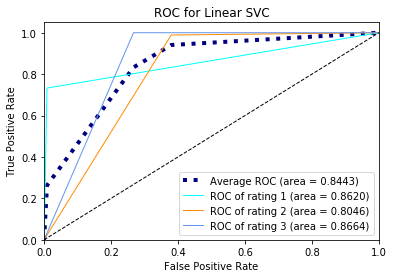

Best ROC score for Linear SVC: 0.8443
Model accuracy is 0.5589225589225589


In [265]:
# Compute ROC AUC score
linear_svc_result = compute_roc_auc_in_classes(y_test, y_score, num_classes=n_classes)

# Draw ROC plot
draw_roc_auc_in_classes(linear_svc_result, 'Linear SVC', num_classes=n_classes)

# Assign Best ROC value
roc_linear_svc = linear_svc_result['roc_auc']["macro"]
print('Best ROC score for Linear SVC: {0:0.4f}'.format(roc_linear_svc))

score_linear_svc = best_linear_svc.score(X_test, y_test)
print('Model accuracy is', score_linear_svc)

In [266]:
# Step 5. Solve with Neural Network

In [267]:
from sklearn.neural_network import MLPClassifier  

# create model for multi-class and one vs rest mode
mlp_nn = OneVsRestClassifier(MLPClassifier(early_stopping=True, random_state=1))
print('Created MLP')
#print("parameters: ", mlp_nn.get_params().keys())

# Create GridSearch to find best model
# Tested:
#   hidden_layer_sizes_param = [(2,),(3,),(4,),(5,),(10,),(2,1),(2,2),(3,3),(4,4),(5,5),(10,10)]
#   max_iter_param = [10, 50, 60, 70, 80, 100, 500]
#   activation_param = ['relu','tanh']
#   learning_rate_param = ['constant', 'invscaling', 'adaptive']
#   solver_param = ['lbfgs', 'sgd', 'adam']
# Best Parameters {'estimator__activation': 'tanh', 
#                  'estimator__hidden_layer_sizes': (3,), 
#                  'estimator__learning_rate': 'constant', 
#                  'estimator__max_iter': 60, 
#                  'estimator__solver': 'adam'}
# So to save time, run with best parameters
#hidden_layer_sizes_param = [(2,),(3,),(4,),(5,),(10,),(2,1),(2,2),(3,3),(4,4),(5,5),(10,10)]
hidden_layer_sizes_param = [(2,),(3,),(4,),(5,),(10,),(2,1),(2,2),(3,3),(4,4),(5,5),(10,10)]
max_iter_param = [ 1000 ]
activation_param = [ 'relu', 'logistic', 'tanh' ]
learning_rate_param = ['constant', 'adaptive']
solver_param = ['lbfgs', 'sgd', 'adam']

hyperparameters = dict(estimator__hidden_layer_sizes=hidden_layer_sizes_param, 
                       estimator__max_iter=max_iter_param,
                       estimator__activation=activation_param,
                       estimator__learning_rate=learning_rate_param,
                       estimator__solver=solver_param)

# Fit model using gridsearch
score_making_func = make_scorer(roc_auc_score, average='macro')
grid_mlp_nn = GridSearchCV(mlp_nn, hyperparameters, scoring=score_making_func, verbose=0)

Created MLP


In [268]:
timer_check = time.time()
print('start training')

# Best model
best_mlp_nn = grid_mlp_nn.fit(X_train, y_train)

print('training spent: ', show_time_spent(timer_check))

#Print all the Parameters that gave the best results:
print('Best Parameters', grid_mlp_nn.best_estimator_.get_params()['estimator'])

start training
training spent:  0:3:2
Best Parameters MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(2, 2), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)


In [269]:
# Compute test scores
y_score = best_mlp_nn.predict(X_test)
print('y_score: ', y_score.shape)

# Print confusion scores
print_confusion_matix(y_test, y_score)

y_score:  (1188, 3)

[[[  63   51]
  [  22 1052]]

 [[ 980  118]
  [  15   75]]

 [[1144   20]
  [  13   11]]]
              precision    recall  f1-score   support

           0     0.9538    0.9795    0.9665      1074
           1     0.3886    0.8333    0.5300        90
           2     0.3548    0.4583    0.4000        24

   micro avg     0.8576    0.9579    0.9050      1188
   macro avg     0.5657    0.7571    0.6322      1188
weighted avg     0.8988    0.9579    0.9220      1188
 samples avg     0.9014    0.9579    0.9199      1188




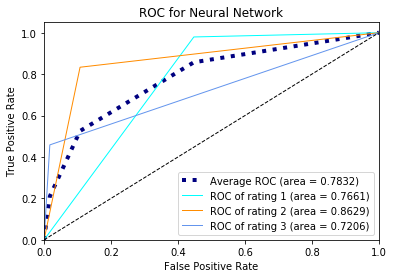

Best ROC score for Neural Network: 0.7832
Model accuracy is 0.7831939699743526


In [270]:
# Compute ROC AUC score
mlp_nn_result = compute_roc_auc_in_classes(y_test, y_score, num_classes=n_classes)

# Draw ROC plot
draw_roc_auc_in_classes(mlp_nn_result, 'Neural Network', num_classes=n_classes)

# Assign Best ROC value
roc_mlp_nn = mlp_nn_result['roc_auc']["macro"]
print('Best ROC score for Neural Network: {0:0.4f}'.format(roc_mlp_nn))

score_mlp_nn = best_mlp_nn.score(X_test, y_test)
print('Model accuracy is', score_mlp_nn)

Best ROC score for Neural Network: 0.7832
Model accuracy is 0.7831939699743526


In [271]:
# Step 6. Solve with Random Forest

In [272]:
from sklearn.ensemble import RandomForestClassifier  

# create model for multi-class and one vs rest mode
rnd_forest = OneVsRestClassifier(RandomForestClassifier(warm_start=False, oob_score=True, n_jobs=-1, random_state=1))
                                 
print('Created Random Forest')
#print("parameters: ", rnd_forest.get_params().keys())

# Create GridSearch to find best model
# Tested:
#      n_estimators_param = [ 50, 100, 200]
#      max_depth_param = [10, 20, 40]
#      max_leaf_nodes_param = [ 20, 50, 100 ]
#      max_features_param = [ 20, X_train.shape[1] ]
#      criterion_param = ['entropy', 'gini' ]
#      class_weight_param = ['balanced', 'balanced_subsample', None]
# To save time, only test partial parameters

n_estimators_param = [ 200, 500, 800, 1000]
max_depth_param = [ 10, 20, 40 ]
max_leaf_nodes_param = [ 20, 50, 100 ]
max_features_param = [ 20, X_train.shape[1] ]
criterion_param = [ 'gini' ]
class_weight_param = [ 'balanced' ]

hyperparameters = dict(estimator__n_estimators=n_estimators_param, 
                       estimator__max_depth=max_depth_param, 
                       estimator__max_leaf_nodes=max_leaf_nodes_param, 
                       estimator__max_features=max_features_param,
                       estimator__criterion=criterion_param,
                       estimator__class_weight=class_weight_param )

# Fit model using gridsearch
score_making_func = make_scorer(roc_auc_score, average='macro')
grid_rnd_forest = GridSearchCV(rnd_forest, hyperparameters, scoring=score_making_func, verbose=0)

Created Random Forest


In [273]:
timer_check = time.time()
print('start training')

# Best model
best_rnd_forest = grid_rnd_forest.fit(X_train, y_train)

#Print all the Parameters that gave the best results:
print('Best Parameters', grid_rnd_forest.best_estimator_)

print('training spent: ', show_time_spent(timer_check))

start training
Best Parameters OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                     class_weight='balanced',
                                                     criterion='gini',
                                                     max_depth=10,
                                                     max_features=20,
                                                     max_leaf_nodes=20,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=800,
                                                     n_jobs=-1, oob_score=True,
   

In [274]:
# Compute test scores
y_score = best_rnd_forest.predict(X_test)
print('y_score: ', y_score.shape)

# Print confusion scores
print_confusion_matix(y_test, y_score)

y_score:  (1188, 3)

[[[  92   22]
  [  63 1011]]

 [[1004   94]
  [  16   74]]

 [[1157    7]
  [  16    8]]]
              precision    recall  f1-score   support

           0     0.9787    0.9413    0.9597      1074
           1     0.4405    0.8222    0.5736        90
           2     0.5333    0.3333    0.4103        24

   micro avg     0.8988    0.9200    0.9093      1188
   macro avg     0.6508    0.6990    0.6479      1188
weighted avg     0.9289    0.9200    0.9193      1188
 samples avg     0.9066    0.9200    0.9111      1188




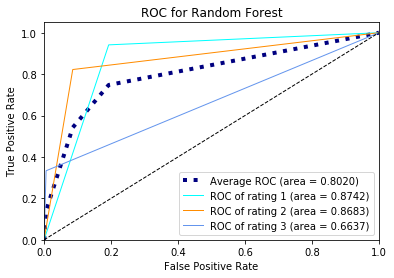

Best ROC score for Random Forest: 0.8020
Model accuracy is 0.8020483225782239


In [275]:
# Compute ROC AUC score
rnd_forest_result = compute_roc_auc_in_classes(y_test, y_score, num_classes=n_classes)

# Draw ROC plot
draw_roc_auc_in_classes(rnd_forest_result, 'Random Forest', num_classes=n_classes)

# Assign Best ROC value
roc_rnd_forest = rnd_forest_result['roc_auc']["macro"]
print('Best ROC score for Random Forest: {0:0.4f}'.format(roc_rnd_forest))

score_rnd_forest = best_rnd_forest.score(X_test, y_test)
print('Model accuracy is', score_rnd_forest)

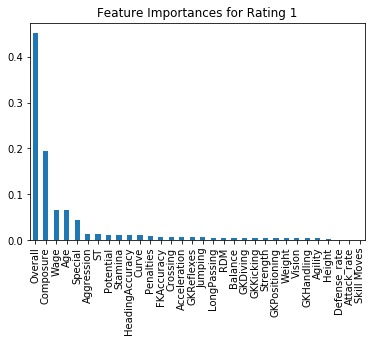

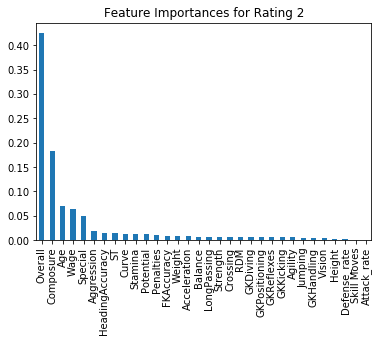

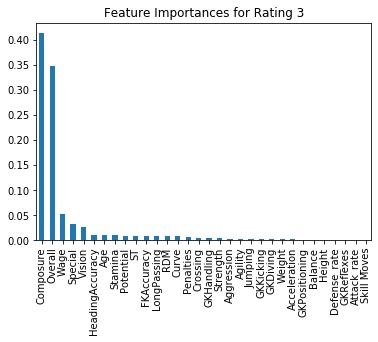

In [276]:
show_feature_importance(grid_rnd_forest.best_estimator_)

In [277]:
# Step 7. Solve with XGBoost

In [278]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier 

xgb_clf = OneVsRestClassifier(XGBClassifier(nthread=4, scale_pos_weight=1,
                                            subsample=0.8,
                                            min_child_weight=1, seed=1))

print("Create XGBoost")

learning_rate_param = np.arange(0.01, 0.1, 0.01)
n_estimators_param = [ 500, 1000, 2000 ]
max_depth_param = [ 10, 20, 50 ]

hyperparameters = dict(estimator__n_estimators=n_estimators_param, 
                       estimator__max_depth=max_depth_param, 
                       estimator__learning_rate=learning_rate_param )

# Fit model using gridsearch
score_making_func = make_scorer(roc_auc_score, average='macro')
grid_xgb_clf = GridSearchCV(xgb_clf, hyperparameters, scoring=score_making_func, verbose=0)

Create XGBoost


In [279]:
timer_check = time.time()
print('start training')

# Best model
best_xgb_clf = grid_xgb_clf.fit(X_train, y_train)

#Print all the Parameters that gave the best results:
print('Best Parameters', grid_xgb_clf.best_estimator_)

print('training spent: ', show_time_spent(timer_check))

start training
Best Parameters OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            learning_rate=0.05,
                                            max_delta_step=0, max_depth=20,
                                            min_child_weight=1, missing=None,
                                            n_estimators=2000, n_jobs=1,
                                            nthread=4,
                                            objective='binary:logistic',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=1,
                                            seed=1, silent=None, subsample=0.8,
                                       

In [280]:
# Compute test scores
y_score = best_xgb_clf.predict(X_test)
print('y_score: ', y_score.shape)

# Print confusion scores
print_confusion_matix(y_test, y_score)

y_score:  (1188, 3)

[[[  68   46]
  [  30 1044]]

 [[1063   35]
  [  56   34]]

 [[1155    9]
  [  15    9]]]
              precision    recall  f1-score   support

           0     0.9578    0.9721    0.9649      1074
           1     0.4928    0.3778    0.4277        90
           2     0.5000    0.3750    0.4286        24

   micro avg     0.9235    0.9150    0.9192      1188
   macro avg     0.6502    0.5749    0.6070      1188
weighted avg     0.9133    0.9150    0.9133      1188
 samples avg     0.9095    0.9150    0.9113      1188




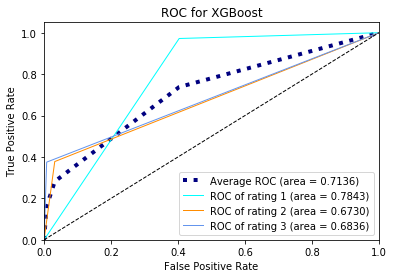

Best ROC score for xgboost: 0.7136
Model accuracy is 0.7136213246262827


In [281]:
# Compute ROC AUC score
rnd_xgboost_result = compute_roc_auc_in_classes(y_test, y_score, num_classes=n_classes)

# Draw ROC plot
draw_roc_auc_in_classes(rnd_xgboost_result, 'XGBoost', num_classes=n_classes)

# Assign Best ROC value
roc_xgboost = rnd_xgboost_result['roc_auc']["macro"]
print('Best ROC score for xgboost: {0:0.4f}'.format(roc_xgboost))

score_xgb_clf = best_xgb_clf.score(X_test, y_test)
print('Model accuracy is', score_xgb_clf)

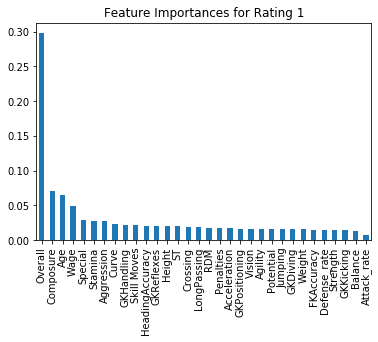

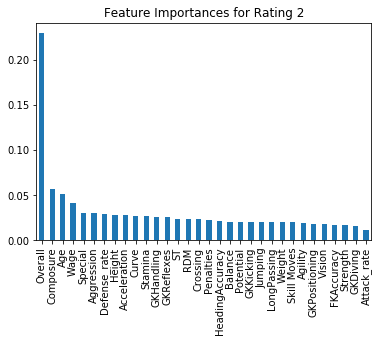

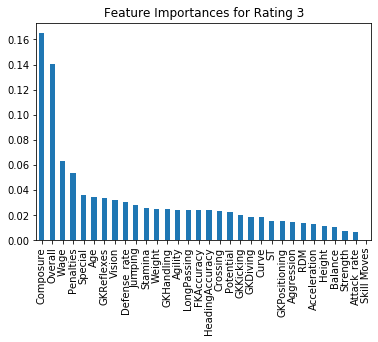

In [282]:
show_feature_importance(grid_xgb_clf.best_estimator_)

In [283]:
# Step 8. Solve with Voting Classifier

In [320]:
# Store best results for different model
avail_models = [
    {'name': 'Logistic Regression', 'roc_auc': roc_logreg, 'model': best_logreg, 'score': score_logreg},
    {'name': 'Decision Tree', 'roc_auc': roc_decision_tree, 'model': best_decision_tree, 'score': score_decision_tree},
    {'name': 'Linear SVC', 'roc_auc': roc_linear_svc, 'model': best_linear_svc, 'score': score_linear_svc},
    {'name': 'Neural Network', 'roc_auc': roc_mlp_nn, 'model': best_mlp_nn, 'score': score_mlp_nn},
    {'name': 'Random Forest', 'roc_auc': roc_rnd_forest, 'model': best_rnd_forest, 'score': score_rnd_forest},
    {'name': 'XGBoost', 'roc_auc': roc_xgboost, 'model': best_xgb_clf, 'score': score_xgb_clf}
]

# Sort based on ROC area values
avail_models.sort(key = lambda sortKey : sortKey['score'], reverse=True)
models_list = [(model['name'], model['score']) for model in avail_models]
print(*models_list, sep='\n')

('Logistic Regression', 0.8223905723905723)
('Random Forest', 0.8020483225782239)
('Neural Network', 0.7831939699743526)
('XGBoost', 0.7136213246262827)
('Decision Tree', 0.6887448489952869)
('Linear SVC', 0.5589225589225589)


In [321]:
# We will compare and choose the best 2 models to create voting classifier to estimate the results,
voting_estimators = []
sel_estimators = []

for i in (0, 1):
    best_model_name, best_score = (avail_models[i]['name'], avail_models[i]['score'])
    voting_estimators.append(avail_models[i]['model'])
    sel_estimators.append((avail_models[i]['name'], avail_models[i]['model']))
    print('{0} - best_model_name: {1}, score: {2:0.4f}'.format(i, best_model_name, best_score))

0 - best_model_name: Logistic Regression, score: 0.8224
1 - best_model_name: Random Forest, score: 0.8020


In [322]:
# Since sklearn.ensemble.VotingClassifier does not support multi-class, 
# so create HybidClassifier to support multi-class majority voting classifier
# ref: https://sebastianraschka.com/Articles/2014_ensemble_classifier.html

from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
import numpy as np
import operator

class HybridClassifier(BaseEstimator, ClassifierMixin):
    """
    Ensemble classifier for scikit-learn estimators.

    Parameters
    ----------

    clf : `iterable`
      A list of scikit-learn classifier objects.
    weights : `list` (default: `None`)
      If `None`, the majority rule voting will be applied to the predicted class labels.
        If a list of weights (`float` or `int`) is provided, the averaged raw probabilities (via `predict_proba`)
        will be used to determine the most confident class label.

    """
    def __init__(self, clfs, weights=None):
        self.clfs = clfs
        self.weights = weights
        # Validation index
        self.v_index = -1

    def fit(self, X, y):
        """
        Fit the scikit-learn estimators.

        Parameters
        ----------

        X : numpy array, shape = [n_samples, n_features]
            Training data
        y : list or numpy array, shape = [n_samples]
            Class labels

        """
        for clf in self.clfs:
            clf.fit(X, y)

    def set_max_value(self, avg_arr):
        max_item_index = np.argmax(avg_arr)
        for index, value in enumerate(avg_arr):
            if index == max_item_index:
                avg_arr[index] = 1
            else:
                avg_arr[index] = 0
        
        #print(avg_arr)
        
    def predict(self, X):
        """
        Parameters
        ----------

        X : numpy array, shape = [n_samples, n_features]

        Returns
        ----------

        maj : list or numpy array, shape = [n_samples]
            Predicted class labels by majority rule

        """

        self.classes_ = np.asarray([clf.predict(X) for clf in self.clfs])
        #print("self.classes_: ", self.classes_.shape)
        #print("self.classes_[:,c]: ", self.classes_[:,0])
        #print("np.argmax(np.bincount(self.classes_[:,c])): ", np.argmax(np.bincount(self.classes_[:,0])))
                
        if self.weights:
            avg = self.predict_proba(X)
            maj = avg
            
            for row in range(maj.shape[0]):
                self.set_max_value(maj[row])
            
            print('maj shape: ', maj.shape)
            #maj = np.apply_along_axis(lambda x: max(enumerate(x), key=operator.itemgetter(1))[0], axis=1, arr=avg)
        else:
            pred_y_arr = None
            
            for clf in self.clfs:
                if pred_y_arr is None:
                    pred_y_arr = np.array(clf.predict(X))
                else:
                    pred_y_arr += np.array(clf.predict(X))
            
            maj = pred_y_arr
            
            for row in range(maj.shape[0]):
                self.set_max_value(maj[row])
            
            print('maj shape (no weight): ', maj.shape)
            #maj = np.asarray([np.argmax(np.bincount(self.classes_[:,c])) for c in range(self.classes_.shape[1])])
        return maj

    def decision_function(self, X):
        return predict(X)
    
    def predict_proba(self, X):

        """
        Parameters
        ----------

        X : numpy array, shape = [n_samples, n_features]

        Returns
        ----------

        avg : list or numpy array, shape = [n_samples, n_probabilities]
            Weighted average probability for each class per sample.

        """
        self.probas_ = [clf.predict_proba(X) for clf in self.clfs]
        
        probas_arr = np.array(self.probas_)
        print('probas_arr: ', probas_arr.shape)
        
        avg = np.average(self.probas_, axis=0, weights=self.weights)
        print('avg: ', avg.shape)

        if self.v_index >= 0:
            avg = avg[:self.v_index]
        
        return avg
    
    def set_v_index(self, index=-1):
        self.v_index = index
    
    def score(self, X, Y):
        score_list = [clf.score(X, Y) for clf in self.clfs]
        avg_score = np.mean(score_list)
        
        return avg_score

In [323]:
# Create customized voting classifier
#voting_model = HybridClassifier(clfs=voting_estimators)
weights_list = [1 for i in voting_estimators]

voting_model = HybridClassifier(clfs=voting_estimators, weights=weights_list)

# Compute test scores
y_score = voting_model.predict(X_test)
print('y_score: ', y_score.shape)

# Print confusion scores
print_confusion_matix(y_test, y_score)

probas_arr:  (2, 1188, 3)
avg:  (1188, 3)
maj shape:  (1188, 3)
y_score:  (1188, 3)

[[[ 106    8]
  [ 111  963]]

 [[ 966  132]
  [   7   83]]

 [[1163    1]
  [  23    1]]]
              precision    recall  f1-score   support

           0     0.9918    0.8966    0.9418      1074
           1     0.3860    0.9222    0.5443        90
           2     0.5000    0.0417    0.0769        24

   micro avg     0.8813    0.8813    0.8813      1188
   macro avg     0.6259    0.6202    0.5210      1188
weighted avg     0.9359    0.8813    0.8942      1188
 samples avg     0.8813    0.8813    0.8813      1188




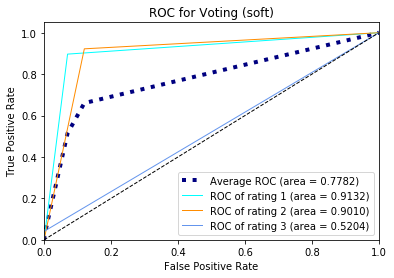

ROC score for Voting Classifiers: 0.7782
Accuracy score for Voting Classifiers: 0.8122


In [324]:
from sklearn.metrics import classification_report

# Compute ROC AUC score
vt_models_result = compute_roc_auc_in_classes(y_test, y_score, num_classes=n_classes)

# Draw ROC plot
draw_roc_auc_in_classes(vt_models_result, 'Voting (soft)', num_classes=n_classes)

# Show final ROC value which is better than 3 best models
roc_vt_models = vt_models_result['roc_auc']["macro"]
print('ROC score for Voting Classifiers: {0:0.4f}'.format(roc_vt_models))

score_vt_models = voting_model.score(X_test, y_test)
print('Accuracy score for Voting Classifiers: {0:0.4f}'.format(score_vt_models))

avail_models.append({'name': 'Voting', 'roc_auc': roc_vt_models, 
                     'model': voting_model, 'score': score_vt_models})

In [356]:
# Sort based on ROC area values
avail_models.sort(key = lambda sortKey : sortKey['score'], reverse=True)

# Even the voting classifier is not performed better than Logistic Regression,
# but voting classifier is more stable than Logistic Regress,
# so we will still choose Voting classifier model as final model
for i in range(len(avail_models)):
    best_model_name, model_score = (avail_models[i]['name'], avail_models[i]['score'])
    print('{0} - model name: {1}, score: {2:0.4f}'.format(i, best_model_name, model_score))

0 - model name: Logistic Regression, score: 0.8224
1 - model name: Voting, score: 0.8122
2 - model name: Random Forest, score: 0.8020
3 - model name: Neural Network, score: 0.7832
4 - model name: XGBoost, score: 0.7136
5 - model name: Decision Tree, score: 0.6887
6 - model name: Linear SVC, score: 0.5589


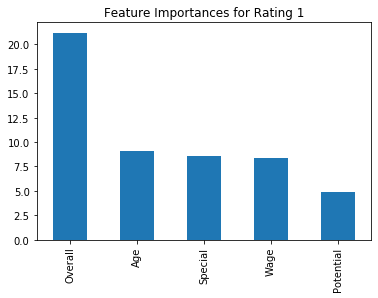

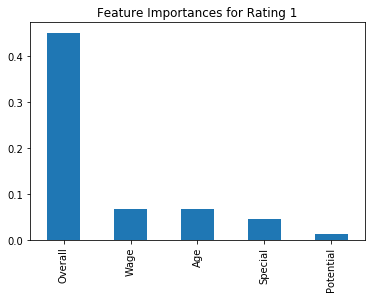

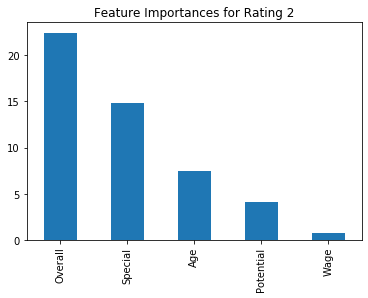

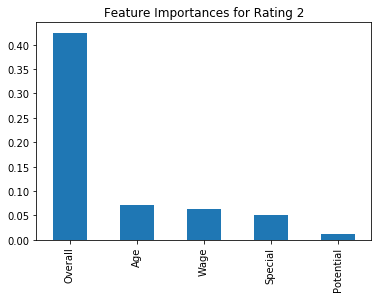

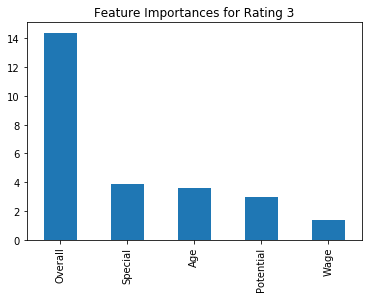

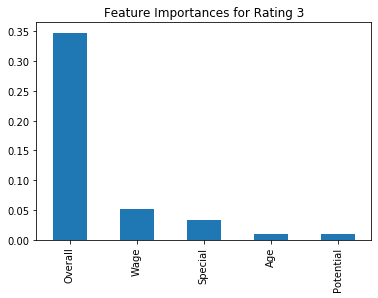

In [363]:
# The features importance can be shown from Logistic Regression
# and Random Forest
for i in range(n_classes):
    show_feature_importance(grid_logreg.best_estimator_, feature_importance_func=get_log_reg_feature_importance, 
                            index=i, max_cols=5)
    show_feature_importance(grid_rnd_forest.best_estimator_, index=i, max_cols=5)
    print()
